In [1]:
import os
import torch
from torch import nn
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from helpers import get_files_in_dir
from torchvision.io import read_image

from embed import PatchEmbedding


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
from figures_dataset import FiguresData
train_dataset = FiguresData(128,2000, augment=True)
print("Training ponits: ",len(train_dataset))

valid_dataset = FiguresData(128,300, augment=False)
print("Validation ponits: ",len(valid_dataset))


Training ponits:  2000
Validation ponits:  300


In [4]:
# from animals_dataset import AnimalsDataset
# train_dataset = AnimalsDataset(128, "animals_data/train", augment=True)
# print("Training ponits: ",len(train_dataset))
# valid_dataset = AnimalsDataset(128, "animals_data/valid", augment=False)
# print("Validation ponits: ",len(valid_dataset))

In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


tensor(1, device='cuda:0')


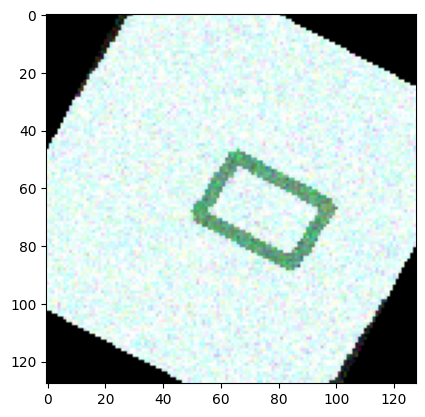

tensor(1, device='cuda:0')


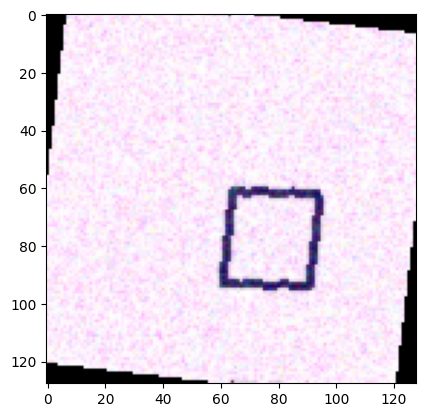

tensor(3, device='cuda:0')


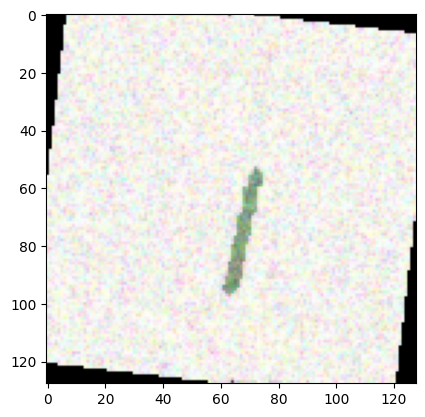

tensor(3, device='cuda:0')


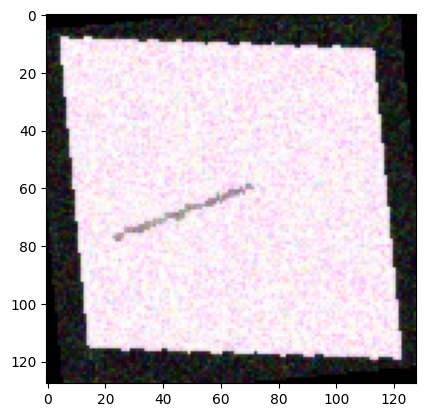

tensor(3, device='cuda:0')


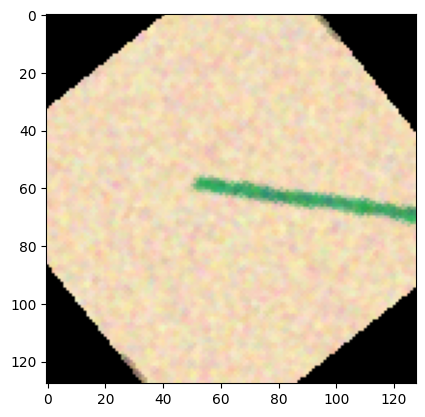

In [6]:
#terate training_set and visualize 
for i in range(5):
    # random int 
    j = torch.randint(0, len(train_dataset),(1,)).item() 
    print(train_dataset[j][1])
    plt.imshow(train_dataset[j][0].permute(1, 2, 0).to('cpu'))
    plt.show()

In [7]:
# TRAINING IMPORTS
from torch import nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torcheval.metrics.functional import multiclass_accuracy
from torch.nn import CrossEntropyLoss
from tit import tit
from simple import SimpleModel
from feature_eng import FModel

Using cuda device
torch.Size([32, 5])
Using cuda device
torch.Size([32, 5])


In [13]:
# MODEL
model_config = {
    "img_size": 128,
    "classes": 5,
    "id_" : 1,
    "patch_size" : 16,
    "embed_dim" : 64,
}

from_checkpoint = False

model = FModel(**model_config)

if from_checkpoint:
    p = 'nip_models/model_{}.pt'.format(model.id_)
    model.load_state_dict(torch.load(p, weights_only=True))

model = model.to(device)



model.print_sizes()

for i, batch in zip(range(len(train_loader)),train_loader):
    images, labels = batch
    with torch.no_grad():   
        ret = model(images.to(device))
        print(ret.shape)
    break



Patch Embed:  torch.Size([64, 256])  Grad:  True
Pos Embed:  torch.Size([1, 64, 64])  Grad:  True
Head:  torch.Size([128, 256])  Grad:  True
cor1_w torch.Size([]) 1
cor2_w torch.Size([]) 1
main_w torch.Size([]) 1
f_corr_w torch.Size([]) 1
batch_norm.weight torch.Size([3]) 3
batch_norm.bias torch.Size([3]) 3
patch_embed.pos_embed torch.Size([1, 64, 64]) 4096
patch_embed.patch_embed.weight torch.Size([64, 256]) 16384
patch_embed.patch_embed.bias torch.Size([64]) 64
patch_embed.layernorm.weight torch.Size([64]) 64
patch_embed.layernorm.bias torch.Size([64]) 64
cross_path.0.weight torch.Size([96, 128]) 12288
cross_path.0.bias torch.Size([96]) 96
cross_path.2.weight torch.Size([64, 96]) 6144
cross_path.2.bias torch.Size([64]) 64
cross_path.3.weight torch.Size([64]) 64
cross_path.3.bias torch.Size([64]) 64
cross_path2.0.weight torch.Size([96, 128]) 12288
cross_path2.0.bias torch.Size([96]) 96
cross_path2.2.weight torch.Size([64, 96]) 6144
cross_path2.2.bias torch.Size([64]) 64
cross_path2.3.

In [45]:
model.switch_mode(1)

model.req_grad(model, False)

model.req_grad(model.head, True)


In [46]:
# TRAINING LOOP
torch.autograd.set_detect_anomaly(False)

epochs = 80
step_size=10
lr = 0.0001

optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
optimizer.zero_grad()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.4) #learning rate decay
criterion = CrossEntropyLoss()
iter_num = 0

lowest_loss = 999
valid_loss = 900
best_epoch = 0

epoch_pbar = tqdm(range(epochs))



for epoch in epoch_pbar:
    train_dataset.new_augment()
    print('Epoch num {}'.format(epoch))
    model.train()
    train_loss = 0

    #batch_pbar = enumerate(tqdm(train_loader))
    #for i,batch in batch_pbar:
    for i, batch in zip(range(len(train_loader)),train_loader):
        images, labels = batch
        images = images.to(torch.float32)
        images = images.to(device)
        labels = labels.to(device)



        pred = model(images)

        
        loss =  criterion(pred,labels)


        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)

        

        train_loss += loss.item()
        iter_num+=1

    train_loss /= (i+1)

    print('Epoch num {}| train loss {} | lr_opt {} \n'.format(epoch,round(train_loss, 4),optimizer.param_groups[0]['lr']))

    if (epoch == 0) or (epoch > 4 and epoch % 5 == 0):
        model.eval()
        valid_loss = 0
        valid_accuracy = 0
        with torch.no_grad():
            for i, batch in zip(range(len(valid_loader)),valid_loader):
                images, labels = batch
                images = images.to(torch.float32)
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)

                loss =  criterion(pred,labels)
                valid_loss += loss.item()
                valid_accuracy += multiclass_accuracy(pred, labels)

        valid_loss /= (i+1)
        valid_accuracy /= (i+1)

            
        print('##########\nValidation loss {} | Validation accuracy {}\n##########'.format(round(valid_loss, 4), round(valid_accuracy.item(), 4)))

    

    if(epoch == 0):
        lowest_loss = valid_loss
    

    if valid_loss < lowest_loss: #(valid_loss + 0.01) < lowest_loss:
        lowest_loss = valid_loss
        best_epoch = epoch
        #print('New lowest loss: {} at epoch {}'.format(round(lowest_loss, 4), best_epoch))
    
    # elif epoch>20 and epoch - best_epoch > 8:
    #     print('Early stopping at epoch {}. Best epoch: {} with score {} '.format(epoch, best_epoch, lowest_loss))
    #     break 
    
    # change schedulers step size

    scheduler.step_size = step_size + (epoch//5)
    
    scheduler.step()


print('Finished. Best epoch: {} with score {} '.format(best_epoch, lowest_loss))


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch num 0
Epoch num 0| train loss 0.3645 | lr_opt 0.0001 

##########
Validation loss 0.5471 | Validation accuracy 0.8066
##########
Epoch num 1
Epoch num 1| train loss 0.3445 | lr_opt 0.0001 

Epoch num 2
Epoch num 2| train loss 0.38 | lr_opt 0.0001 

Epoch num 3
Epoch num 3| train loss 0.3804 | lr_opt 0.0001 

Epoch num 4
Epoch num 4| train loss 0.347 | lr_opt 0.0001 

Epoch num 5
Epoch num 5| train loss 0.3611 | lr_opt 0.0001 

##########
Validation loss 0.5355 | Validation accuracy 0.8135
##########
Epoch num 6
Epoch num 6| train loss 0.3462 | lr_opt 0.0001 

Epoch num 7
Epoch num 7| train loss 0.3485 | lr_opt 0.0001 

Epoch num 8
Epoch num 8| train loss 0.3813 | lr_opt 0.0001 

Epoch num 9
Epoch num 9| train loss 0.3571 | lr_opt 0.0001 

Epoch num 10
Epoch num 10| train loss 0.3316 | lr_opt 0.0001 

##########
Validation loss 0.5342 | Validation accuracy 0.8096
##########
Epoch num 11
Epoch num 11| train loss 0.3534 | lr_opt 0.0001 

Epoch num 12
Epoch num 12| train loss 0.3449 

KeyboardInterrupt: 

In [32]:
def evaluate_model(model, valid_loader):
    entropy = CrossEntropyLoss()
    accuracy = multiclass_accuracy
    valid_loss = 0
    valid_accuracy = 0
    model.eval()
    with torch.no_grad():
        for i, batch in zip(range(len(valid_loader)),valid_loader):
            images, labels = batch
            images = images.to(torch.float32)
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            loss =  entropy(pred,labels)
            valid_loss += loss.item()
            valid_accuracy += accuracy(pred, labels)

    valid_loss /= (i+1)
    valid_accuracy /= (i+1)
    return {'loss': valid_loss, 'accuracy': valid_accuracy}


In [38]:
valid_dataset = FiguresData(128,1000, augment=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
print("Validation ponits: ",len(valid_dataset))
evaluate_model(model, valid_loader)

Validation ponits:  1000


{'loss': 0.48262433311901987, 'accuracy': tensor(0.8369, device='cuda:0')}

In [ ]:
# save model
model.eval()
torch.save(model.state_dict(), 'nip_models/model_{}.pt'.format(model.id_))

In [ ]:
#Del model
model.eval()
model.cpu()
del(model)

NameError: name 'model' is not defined

In [ ]:
import torch

In [ ]:

def new_data():
    train_inp = torch.rand((1000,1,10))

    train_tar = torch.rand((1000,1,1))

    for _,b in enumerate(train_inp):
        #print(b.shape)
        for _,i in enumerate(b):
            i = torch.prod(i)
            i = i*i
            train_tar[_] = i
            #print(i)
    return train_inp, train_tar




In [ ]:
a = torch.nn.Linear(10,5)
b = torch.nn.Linear(5,1)
#b.weight.data.fill_(1)
a.bias.data.fill_(0)
weights_layer = torch.nn.Sequential(
    torch.nn.Linear(5,25),
    torch.nn.ReLU(),
    torch.nn.Linear(25,25),
    torch.nn.ReLU(),
    torch.nn.Linear(25,5),
)
train_inp, train_tar = new_data()
for j in range(10):
    #
    step = 0.1 /(2*(j+1))
    loss_epoch = 0
    for i in range(1000):
        # inp = torch.rand((1,10), requires_grad=False, dtype=torch.float32) 
        # tru = torch.prod(inp)
        # tru = tru*tru
        inp = train_inp[i]
        tru = train_tar[i]
        #print(inp.shape, tru.shape)


        A = weights_layer(a.weight.transpose(0,1))
        x = torch.matmul(inp,A)

        x = torch.nn.functional.relu(x)

        x = b(x)

        # loss
        loss = torch.abs(x - tru)
        #print(loss.mean())
        loss.backward(gradient=torch.ones_like(loss))

        a.weight = torch.nn.Parameter(A.transpose(0,1))

        
        with torch.no_grad():
            for l in weights_layer:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                except:
                    pass
            

            b.weight -= step * b.weight.grad
            b.weight.grad.zero_()

        loss_epoch += loss.mean()
        # if i % 100 == 0:
        #     print(loss.mean())
    print(loss_epoch/1000)


tensor(0.7257, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)


In [ ]:
# NORMAL
a = torch.nn.Linear(10,5)
b = torch.nn.Linear(5,1)
#b.weight.data.fill_(1)
#b.bias.data.fill_(0)
train_inp, train_tar = new_data()
for j in range(10):
    
    step = 0.001 /(2*(j+1))
    loss_epoch = 0
    for i in range(1000):
        inp = train_inp[0]
        tru = train_tar[0]
        
        x = a(inp)
        x = torch.nn.functional.relu(x)

        x = b(x)


        # loss
        loss = torch.abs(x - tru)
        loss.backward(gradient=torch.ones_like(loss))

        #step = 0.001
        with torch.no_grad():
            a.weight -= step * a.weight.grad
            b.weight -= step * b.weight.grad
            a.weight.grad.zero_()
            b.weight.grad.zero_()

        loss_epoch += loss.mean()
        # if i % 100 == 0:
        #     print(loss.mean())
    print(loss_epoch/1000)


tensor(0.0239, grad_fn=<DivBackward0>)
tensor(7.1405e-05, grad_fn=<DivBackward0>)
tensor(4.7624e-05, grad_fn=<DivBackward0>)
tensor(3.5727e-05, grad_fn=<DivBackward0>)
tensor(2.8560e-05, grad_fn=<DivBackward0>)
tensor(2.3820e-05, grad_fn=<DivBackward0>)
tensor(2.0394e-05, grad_fn=<DivBackward0>)
tensor(1.7854e-05, grad_fn=<DivBackward0>)


KeyboardInterrupt: 

In [ ]:
# WITH INPUT, BIAS, ERROR
a = torch.nn.Linear(10,5)
b = torch.nn.Linear(5,1)
#b.weight.data.fill_(1)
#b.bias.data.fill_(0)
weights_layer = torch.nn.Sequential(
    torch.nn.Linear(5,25),
    torch.nn.ReLU(),
    torch.nn.Linear(25,25),
    torch.nn.ReLU(),
)
bias_layer = torch.nn.Sequential(
    torch.nn.Linear(5,25),
    torch.nn.ReLU(),
    torch.nn.Linear(25,25),
    torch.nn.ReLU(),
)
input_layer = torch.nn.Sequential(
    torch.nn.Linear(10,50),
    torch.nn.ReLU(),
    torch.nn.Linear(50,25),
    torch.nn.ReLU(),
)

pred_weights = torch.nn.Sequential(
    torch.nn.Linear(76,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,5),
)

pred_bias = torch.nn.Sequential(
    torch.nn.Linear(760,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,50),
    torch.nn.ReLU(),
    torch.nn.Linear(50,5),
)





#train_inp, train_tar = new_data()
for j in range(1):
    #
    step = 0.0001# /(2*(j+1))
    loss_epoch = 0
    for i in range(10000):
        inp = train_inp[i][0]
        tru = train_tar[i][0]

        x = a(inp)
        x = torch.nn.functional.relu(x)
        x = b(x)

        # 1 x 25
        loss = torch.abs(x - tru)
        # 1 x 25
        in_ftrs = input_layer(inp)
        # 10 x 25
        w_ftrs = weights_layer(a.weight.transpose(0,1))
        # 1 x 25
        b_ftrs = bias_layer(a.bias)

        buff = torch.cat((in_ftrs,b_ftrs, loss))
        buff = buff.expand(10,-1)
        
        all_ftrs = torch.cat((buff,w_ftrs),dim=1)

        new_weights = pred_weights(all_ftrs)
        all_ftrs_f = all_ftrs.flatten()
        new_bias = pred_bias(all_ftrs_f)

        a.weight = torch.nn.Parameter(new_weights.transpose(0,1))
        a.bias = torch.nn.Parameter(new_bias)

        y = torch.matmul(inp,new_weights) + new_bias
        y = torch.nn.functional.relu(y)
        y = b(y)
        loss = torch.abs(y - tru)


        # loss
        #print(loss.mean())
        #loss.backward(gradient=torch.ones_like(loss))
        loss.backward()
        

        
        with torch.no_grad():
            for l in weights_layer:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                    #print("updated")
                except:
                    pass
            for l in bias_layer:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                except:
                    pass
            for l in input_layer:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                except:
                    pass
            for l in pred_weights:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                except:
                    pass
            for l in pred_bias:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                except:
                    pass
            
            

            b.weight -= step * b.weight.grad
            b.weight.grad.zero_()

        loss_epoch += loss
        if i % 100 == 0:
            print(loss_epoch/100)
            loss_epoch = 0
    #print(loss_epoch/1000)


tensor([0.0016], grad_fn=<DivBackward0>)
tensor([0.6873], grad_fn=<DivBackward0>)
tensor([0.6150], grad_fn=<DivBackward0>)
tensor([0.5904], grad_fn=<DivBackward0>)
tensor([0.4907], grad_fn=<DivBackward0>)
tensor([0.3880], grad_fn=<DivBackward0>)
tensor([0.3770], grad_fn=<DivBackward0>)
tensor([0.3720], grad_fn=<DivBackward0>)
tensor([0.3700], grad_fn=<DivBackward0>)
tensor([0.3131], grad_fn=<DivBackward0>)
tensor([0.3056], grad_fn=<DivBackward0>)
tensor([0.2880], grad_fn=<DivBackward0>)
tensor([0.3104], grad_fn=<DivBackward0>)
tensor([0.2849], grad_fn=<DivBackward0>)
tensor([0.2862], grad_fn=<DivBackward0>)
tensor([0.2761], grad_fn=<DivBackward0>)
tensor([0.2721], grad_fn=<DivBackward0>)
tensor([0.2814], grad_fn=<DivBackward0>)
tensor([0.2783], grad_fn=<DivBackward0>)
tensor([0.2505], grad_fn=<DivBackward0>)
tensor([0.3088], grad_fn=<DivBackward0>)
tensor([0.2470], grad_fn=<DivBackward0>)
tensor([0.2684], grad_fn=<DivBackward0>)
tensor([0.2961], grad_fn=<DivBackward0>)
tensor([0.2753],

In [ ]:
# WITH GRADIENT and ERROR ( step prediction)
a = torch.nn.Linear(10,5)
b = torch.nn.Linear(5,1)
b.weight.data.fill_(1)
b.bias.data.fill_(0)
gradient_layer = torch.nn.Sequential(
    torch.nn.Linear(5,50),
    torch.nn.ReLU(),
    torch.nn.Linear(50,25),
    torch.nn.ReLU(),
)
error_layer = torch.nn.Sequential(
    torch.nn.Linear(1,5),
    torch.nn.ReLU(),
    torch.nn.Linear(5,5),
    torch.nn.ReLU(),
)

step_layer = torch.nn.Sequential(
    torch.nn.Linear(30,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,5),
)


#torch.autograd.set_detect_anomaly(True)


#train_inp, train_tar = new_data()
for j in range(3):
    #
    step = 0.0001# /(2*(j+1))
    loss_epoch = 0
    for i in range(10000):
        inp = train_inp[0][0]
        tru = train_tar[0][0]

        x = a(inp)
        x = torch.nn.functional.relu(x)
        x = b(x)

        # 1 x 25
        loss = torch.abs(x - tru)
        loss.backward()

        a.weight.grad.zero_()
        a.bias.grad.zero_()
        b.weight.grad.zero_()
        b.bias.grad.zero_()

        
        
        grad_ftrs = gradient_layer(a.weight.grad.transpose(0,1))
        err_ftrs = error_layer(loss).expand(10,-1)
        # # concat
        buff = torch.cat((grad_ftrs,err_ftrs),1)
        # # 1 x 30
        steps = step_layer(buff).transpose(0,1)
        
        new_a_w = a.weight - (steps * step)

        


        x = torch.matmul(inp,new_a_w.transpose(0,1)) + a.bias
        x = torch.nn.functional.relu(x)
        #x = torch.matmul(x,b.weight.transpose(0,1)) + b.bias
        loss_ = torch.abs(x - tru)
        loss_.backward(gradient=torch.ones_like(loss_))


        


        # loss
        #print(loss.mean())
        #loss.backward(gradient=torch.ones_like(loss))
        
        

        
        with torch.no_grad():
            
            
            a.weight.grad.zero_()

            for l in gradient_layer:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                    #print("updated")
                except:
                    pass
            for l in error_layer:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                except:
                    pass
            for l in step_layer:
                try:
                    l.weight -= step * l.weight.grad
                    l.weight.grad.zero_()
                except:
                    pass
            

            #b.weight -= step * b.weight.grad
            #b.weight.grad.zero_()

        loss_epoch += loss
        if i % 100 == 0:
            print(loss_epoch/100)
            loss_epoch = 0
    #print(loss_epoch/1000)

c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Error detected in AbsBackward0. Traceback of forward call that caused the error:
  File "c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\newma\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\newma\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\newma\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "C:\Users\newma\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "C:\Users\newma\AppData\Roaming\Python\Python310\site-packages\tornado\platfo

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [12]:
import torch
from einops import rearrange, repeat

In [ ]:
#a = torch.rand((2,2,3))
a = torch.rand((32,5,10))
out = torch.empty((32,5,5,20))
#print(torch.combinations(a,2, with_replacement=True))
#print(torch.combinations(a,2, with_replacement=False))

#a.repeat(1,5,1).shape
c = a.unsqueeze(2)
c = c.expand(32,5,5,10)



#d = a.unsqueeze(1)

c  = c.reshape(32,25,10)

out = rearrange(c, 'b (ps pss) e -> b (pss ps) e',
                      ps = 5, pss = 5)
#c = c.sum(dim=2)
#out = out.sum(dim=2)

ret = torch.cat((c,out),dim=2)

print(c.shape)
print(out.shape)
print(ret.shape)

ret = ret.sum(dim=2)
print(ret.shape)


print(ret[0])








                      

torch.Size([32, 25, 10])
torch.Size([32, 25, 10])
torch.Size([32, 25, 20])
torch.Size([32, 25])
tensor([11.6297, 10.5904, 10.2032,  9.3841, 12.0843, 10.5904,  9.5510,  9.1639,
         8.3448, 11.0449, 10.2032,  9.1639,  8.7767,  7.9576, 10.6578,  9.3841,
         8.3448,  7.9576,  7.1386,  9.8387, 12.0843, 11.0449, 10.6578,  9.8387,
        12.5389])


In [ ]:
#a = torch.rand((2,2,3))

batch = 2
patches = 17
embed = 100

# a = torch.rand((32,5,10))
# out = torch.empty((32,5,5,20))
a = torch.rand((batch,patches,embed))
#out = torch.empty((batch,patches,patches,2*embed))

#a.repeat(1,5,1).shape
c = a.unsqueeze(2)
c = c.expand(batch,patches,patches,embed)
c  = c.reshape(batch,patches*patches,embed)


out = rearrange(c, 'b (ps pss) e -> b (pss ps) e',
                      ps = patches, pss = patches)

ret = torch.cat((c,out),dim=2)
ret = ret.reshape(batch,patches,patches,2*embed)

print(c.shape)
print(out.shape)
print(ret.shape)

ret = ret.sum(dim=3)
print(ret.shape)


print(ret[0][1][0] == ret[0][0][1])


torch.Size([2, 289, 100])
torch.Size([2, 289, 100])
torch.Size([2, 17, 17, 200])
torch.Size([2, 17, 17])
tensor(True)


In [ ]:
# B x P x P x E
batch = 2
patches = 17
embed = 100

a = torch.rand((batch,patches,embed))
print(a.shape)
a = a[:,0:16,:]

# a = rearrange(a, 'b (x y) e -> b x y (y e)',
#                         y = 2)


# a = a.reshape(dims)

print(a.shape)

torch.Size([2, 17, 100])
torch.Size([2, 16, 100])


In [ ]:
a = torch.rand((batch,patches,embed))
W = torch.rand((embed,embed))
torch.matmul(a,W).shape

torch.Size([2, 17, 100])

In [ ]:
a = torch.rand((batch,patches,embed))
b = torch.rand((1,embed))
#b = b.unsqueeze(0)
print(b.shape)
b = b.expand(batch,embed)
#b = b.reshape(1,batch*patches,embed)
print(b.shape)
#a = torch.stack((a,b),dim=1)
a = a.reshape(batch,patches*embed)
a = torch.cat((a,b),dim=1)
a.shape


torch.Size([1, 100])
torch.Size([2, 100])


torch.Size([2, 1800])

In [ ]:
a = torch.rand((batch,patches,embed))
b = torch.rand((batch,patches,embed))
# stack
c = torch.stack((a,b),dim=3)
c = c.flatten(2)

print(a[0][0][0])
print(b[0][0][0])
print(c[0][0][0:2])

c.shape

tensor(0.1580)
tensor(0.6416)
tensor([0.1580, 0.6416])


torch.Size([2, 17, 200])

In [66]:
def cartesian_prod_last_dim( x):
        batch = x.shape[0]
        patches = x.shape[1]
        embed = x.shape[2]
        
        # B x P x E -> B x P x 1 x E
        y = x.unsqueeze(2)
        # B x P x 1 x E -> B x P x P x E
        y = y.expand(batch,patches,embed, embed)
        # B x P x P x E -> B x (P x P) x E
        y  = y.reshape(batch,patches,embed * embed)

        # B x (P x P) x E -> B x (P x P) x E
        # but the last dim is no longer the same 
        # (one repeated) embedding
        z = rearrange(y, 'b ps (e ee) -> b ps (ee e)',
                            e = embed, ee = embed)
        #z = z * self.correl_weight
        # cart_prod
        # B x (P x P) x E -> B x P x P x 2E
        ret = torch.cat((y,z),dim=2)
        ret = ret.reshape(batch,patches,2,embed*embed)
        return ret

In [70]:
# rand 10 x 100
a = torch.rand((50))
# cartesian product
b = torch.cartesian_prod(a)

b.shape

# B x P x E
a = torch.rand((32,16,100))
a = cartesian_prod_last_dim(a)
print(a.shape)
#print(a.view(50,2,10).shape)

#a = a.view(50,2,10)
b = a.view(32,16,2,10000)[:,:,0,:]
c = a.view(32,16,2,10000)[:,:,1,:]
print(b.shape)
print(c.shape)

print((b * c).shape)

torch.matmul(torch.rand(10,100),torch.rand((100,100))).shape
torch.matmul(torch.rand(100,10),torch.rand((10,10))).shape

torch.Size([32, 16, 2, 10000])
torch.Size([32, 16, 10000])
torch.Size([32, 16, 10000])
torch.Size([32, 16, 10000])


torch.Size([100, 10])

In [27]:
a = torch.rand((10,5))
b = torch.rand((5,5))
torch.matmul(a,b).shape

torch.Size([10, 5])